# A computational approach to discover CD8+ T-cell receptor characteristics underlying peptide recognition

**TODO**: general introduction about this notebook

In [1]:
# imports
import joblib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from boruta import BorutaPy
from IPython import display
from pyteomics import electrochem, mass, parser
from sklearn import ensemble, feature_extraction, metrics, model_selection, pipeline, preprocessing
%matplotlib inline

pd.options.display.max_rows = 10

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.size'] = 6

## Input data

**TODO**: short explanation about what the data is

In [2]:
data = pd.read_csv('data.csv')
display.display(data)

,V_gene,CDR3_sequence,J_gene,HLA_peptide
0,27,CASSPNGDRVFDQPQHF,1-5,EIYKRWII
1,9,CASSVVGDGRETQYF,2-5,EIYKRWII
2,9,CASSEGQGTTYEQYF,2-5,EIYKRWII
3,2,CASSEAATGRGNQPQHF,1-5,EIYKRWII
4,9,CASSVLHGRQETQYF,2-5,EIYKRWII
...,...,...,...,...
224,7-9,CASSLAPGTSGSPYNEQFF,2-1,FLKEKGGL
225,14,CASSLGTGIANYGYTF,2-1,FLKEKGGL
226,14,CASSLGTGIANYGYTF,2-1,FLKEKGGL
227,24-1,CATKGTGLYNEQFF,2-1,FLKEKGGL


## Feature generation

**TODO**: verify and update details on feature generation

Various features were constructed:
* The prefix and postfix categorical attributes were one-hot encoded. This is useful because most classification algorithms are not able to deal with categorical features but require numerical features instead.
* The sequence length (computed by [Pyteomics](https://pythonhosted.org/pyteomics/) [Goloborodko2013], modX notation allowed).
* The number of times each amino acid occurs in the sequence.
* The average of the chemical properties (basicity, hydrophobicity, helicity) and the substitution of the individual amino acids in the sequence, normalized by the sequence length.
* The pI of the full sequence (computed by [Pyteomics](https://pythonhosted.org/pyteomics/)).
* The peptide mass (computed by [Pyteomics](https://pythonhosted.org/pyteomics/)).
* Individual features of each amino acid at specific positions in the sequences:
    * For sequences with an odd length, the center amino acid is assigned index `0`, with ascending indices to the right and descending indices to the left. For sequences with an even length there is no `0` index, but the center two amino acids have index `-1` and `1`.
    * For each position the following features are generated: which amino acid occurs at this position; the basicity, hydrophobicity, helicity, pI, and substitution value for the amino acid at this position.
    
In total this results in 417 different features for each sequence.

[Goloborodko2013] Goloborodko, A. A., Levitsky, L. I., Ivanov, M. V. & Gorshkov, M. V. Pyteomics-a Python framework for exploratory data analysis and rapid software prototyping in proteomics. *Journal of The American Society for Mass Spectrometry* **24**, 301–304 (2013).

In [3]:
# physicochemical amino acid properties
basicity = {'A': 206.4, 'B': 210.7, 'C': 206.2, 'D': 208.6, 'E': 215.6, 'F': 212.1, 'G': 202.7,
            'H': 223.7, 'I': 210.8, 'K': 221.8, 'L': 209.6, 'M': 213.3, 'N': 212.8, 'P': 214.4,
            'Q': 214.2, 'R': 237.0, 'S': 207.6, 'T': 211.7, 'V': 208.7, 'W': 216.1, 'X': 210.2,
            'Y': 213.1, 'Z': 214.9}

hydrophobicity = {'A': 0.16, 'B': -3.14, 'C': 2.50, 'D': -2.49, 'E': -1.50, 'F': 5.00, 'G': -3.31,
                  'H': -4.63, 'I': 4.41, 'K': -5.00, 'L': 4.76, 'M': 3.23, 'N': -3.79, 'P': -4.92,
                  'Q': -2.76, 'R': -2.77, 'S': -2.85, 'T': -1.08, 'V': 3.02, 'W': 4.88, 'X': 4.59,
                  'Y': 2.00, 'Z': -2.13}

helicity = {'A': 1.24, 'B': 0.92, 'C': 0.79, 'D': 0.89, 'E': 0.85, 'F': 1.26, 'G': 1.15, 'H': 0.97,
            'I': 1.29, 'K': 0.88, 'L': 1.28, 'M': 1.22, 'N': 0.94, 'P': 0.57, 'Q': 0.96, 'R': 0.95,
            'S': 1.00, 'T': 1.09, 'V': 1.27, 'W': 1.07, 'X': 1.29, 'Y': 1.11, 'Z': 0.91}

mutation_stability = {'A': 13, 'C': 52, 'D': 11, 'E': 12, 'F': 32, 'G': 27, 'H': 15, 'I': 10,
                      'K': 24, 'L': 34, 'M':  6, 'N':  6, 'P': 20, 'Q': 10, 'R': 17, 'S': 10,
                      'T': 11, 'V': 17, 'W': 55, 'Y': 31}

In [4]:
# feature conversion and generation
features_list = []

# numeric encoding of the HLA_peptide class labels
features_list.append(pd.DataFrame(preprocessing.LabelEncoder().fit_transform(data['HLA_peptide']),
                                  columns=['HLA_peptide']))

# one-hot encoding of pre and post
onehot_encoder = feature_extraction.DictVectorizer(sparse=False)
features_list.append(pd.DataFrame(
        onehot_encoder.fit_transform(data[['V_gene', 'J_gene']].to_dict(orient='records')),
        columns=onehot_encoder.feature_names_))

# sequence length
features_list.append(data['CDR3_sequence'].apply(
        lambda sequence: parser.length(sequence)).to_frame()
                     .rename(columns={'CDR3_sequence': 'length'}))

# number of occurences of each amino acid
aa_counts = pd.DataFrame.from_records(
    [parser.amino_acid_composition(sequence) for sequence in data['CDR3_sequence']]).fillna(0)
aa_counts.columns = ['count_{}'.format(column) for column in aa_counts.columns]
features_list.append(aa_counts)

# physicochemical properties: (average) basicity, (average) hydrophobicity,
#                             (average) helicity, pI, (average) mutation stability
features_list.append(data['CDR3_sequence'].apply(
        lambda seq: sum([basicity[aa] for aa in seq]) / parser.length(seq))
                     .to_frame().rename(columns={'CDR3_sequence': 'avg_basicity'}))
features_list.append(data['CDR3_sequence'].apply(
        lambda seq: sum([hydrophobicity[aa] for aa in seq]) / parser.length(seq))
                     .to_frame().rename(columns={'CDR3_sequence': 'avg_hydrophobicity'}))
features_list.append(data['CDR3_sequence'].apply(
        lambda seq: sum([helicity[aa] for aa in seq]) / parser.length(seq))
                     .to_frame().rename(columns={'CDR3_sequence': 'avg_helicity'}))
features_list.append(data['CDR3_sequence'].apply(
        lambda seq: electrochem.pI(seq)).to_frame().rename(columns={'CDR3_sequence': 'pI'}))
features_list.append(data['CDR3_sequence'].apply(
        lambda seq: sum([mutation_stability[aa] for aa in seq]) / parser.length(seq))
                     .to_frame().rename(columns={'CDR3_sequence': 'avg_mutation_stability'}))

# peptide mass
features_list.append(data['CDR3_sequence'].apply(
        lambda seq: mass.fast_mass(seq)).to_frame().rename(columns={'CDR3_sequence': 'mass'}))

# positional features
# amino acid occurence and physicochemical properties at a given position from the center
pos_aa, pos_basicity, pos_hydro, pos_helicity, pos_pI, pos_mutation = [[] for _ in range(6)]
for sequence in data['CDR3_sequence']:
    length = parser.length(sequence)
    start_pos = -1 * (length // 2)
    pos_range = list(range(start_pos, start_pos + length)) if length % 2 == 1 else\
                list(range(start_pos, 0)) + list(range(1, start_pos + length + 1))
    
    pos_aa.append({'pos_{}_{}'.format(pos, aa): 1
                   for pos, aa in zip(pos_range, sequence)})
    pos_basicity.append({'pos_{}_basicity'.format(pos): basicity[aa]
                         for pos, aa in zip(pos_range, sequence)})
    pos_hydro.append({'pos_{}_hydrophobicity'.format(pos): hydrophobicity[aa]
                      for pos, aa in zip(pos_range, sequence)})
    pos_helicity.append({'pos_{}_helicity'.format(pos): helicity[aa]
                         for pos, aa in zip(pos_range, sequence)})
    pos_pI.append({'pos_{}_pI'.format(pos): electrochem.pI(aa)
                   for pos, aa in zip(pos_range, sequence)})
    pos_mutation.append({'pos_{}_mutation_stability'.format(pos): mutation_stability[aa]
                         for pos, aa in zip(pos_range, sequence)})

features_list.append(pd.DataFrame.from_records(pos_aa).fillna(0))
features_list.append(pd.DataFrame.from_records(pos_basicity).fillna(0))
features_list.append(pd.DataFrame.from_records(pos_hydro).fillna(0))
features_list.append(pd.DataFrame.from_records(pos_helicity).fillna(0))
features_list.append(pd.DataFrame.from_records(pos_pI).fillna(0))
features_list.append(pd.DataFrame.from_records(pos_mutation).fillna(0))

# combine all features
features = pd.concat(features_list, axis=1)

print('Samples: {} - features: {}'.format(features.shape[0], features.shape[1]))

## Classification

**TODO**: explain pipeline consisting of feature selection and classification
**TODO**: explain repeated CV split to get a robust performance assessment

In [5]:
# run a single iteration of the predictor (extracted to a method for multithreaded computation)
def run_predictor(predictor, X, y, train_index, test_index):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train the predictor pipeline
    predictor.fit(X_train, y_train)
    
    # extract the relevant feature importances
    importances = np.zeros(X.shape[1], float)
    importances[predictor.named_steps['feature_selection'].support_] =\
        predictor.named_steps['classification'].feature_importances_
    
    # return the predictions to evaluate the performance
    predictions_proba = predictor.predict_proba(X_test)[:, 1]
    return (y_test, np.array(predictions_proba > 0.5, np.int)),\
           (y_test, predictions_proba),\
           importances

In [6]:
# create a prediction pipeline consisting of feature selection and classification
classifier = ensemble.RandomForestClassifier(200, n_jobs=-1, random_state=0)
predictor = pipeline.Pipeline([('feature_selection',
                                BorutaPy(ensemble.ExtraTreesClassifier(n_jobs=-1),
                                         n_estimators='auto', random_state=0)),
                               ('classification', classifier)])

In [7]:
# turn off numpy RuntimeWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # apply the prediction pipeline
    features_noclass = features.drop('HLA_peptide', axis=1)
    X = features_noclass.values
    y = features['HLA_peptide'].values

    # do multiple splits to get a more accurate evaluation of the performance
    repeats = 100
    sss = model_selection.StratifiedShuffleSplit(n_splits=repeats, test_size=0.2, random_state=0)

    result = np.asarray(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_predictor)
                                                   (predictor, X, y, train_index, test_index)
                                                   for train_index, test_index in sss.split(X, y)))
    predictions = result[:, 0]
    predictions_proba = result[:, 1]
    feature_importances = result[:, 2]

Classification accuracy = 75.00% ± 5.75%


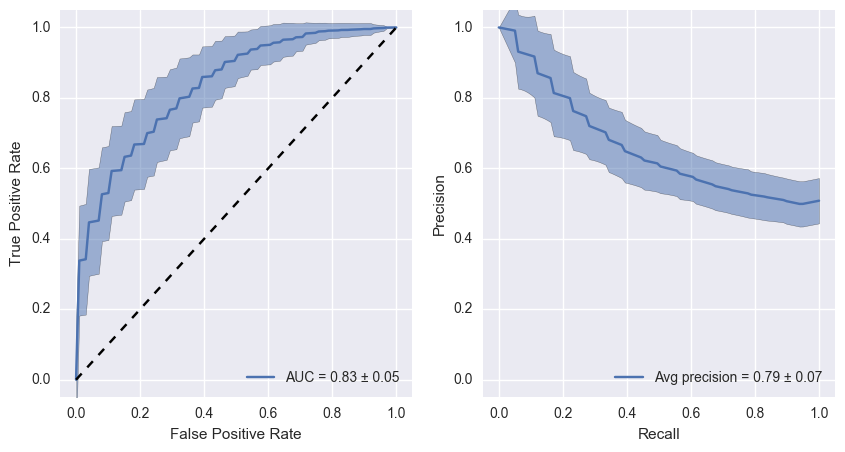

In [8]:
# evaluate the performance of the prediction pipeline
# accuracy
accuracy_mean = np.mean([metrics.accuracy_score(y_test, y_pred)
                         for y_test, y_pred in predictions])
accuracy_std = np.std([metrics.accuracy_score(y_test, y_pred)
                       for y_test, y_pred in predictions])

# AUC and average precision
auc_mean = np.mean([metrics.roc_auc_score(y_test, y_pred)
                    for y_test, y_pred in predictions_proba])
auc_std = np.std([metrics.roc_auc_score(y_test, y_pred)
                  for y_test, y_pred in predictions_proba])
avg_precision_mean = np.mean([metrics.average_precision_score(y_test, y_pred)
                              for y_test, y_pred in predictions_proba])
avg_precision_std = np.std([metrics.average_precision_score(y_test, y_pred)
                            for y_test, y_pred in predictions_proba])
avg_precision_inverted_mean = np.mean([metrics.average_precision_score(1 - y_test, 1 - y_pred)
                                       for y_test, y_pred in predictions_proba])
avg_precision_inverted_std = np.std([metrics.average_precision_score(1 - y_test, 1 - y_pred)
                                     for y_test, y_pred in predictions_proba])

# mean and standard deviation of ROC and precision-recall curves
interval = np.linspace(0, 1, 100)
tprs, precisions, precisions_inverted = [], [], []
for y_test, y_pred in predictions_proba:
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    tprs.append(np.interp(interval, fpr, tpr))
    
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
    precisions.append(np.interp(interval, recall[::-1], precision))
    
    # inverted precision
    precision_inverted, recall_inverted, _ = metrics.precision_recall_curve(1 - y_test, 1 - y_pred)
    precisions_inverted.append(np.interp(interval, recall_inverted[::-1], precision_inverted))
tpr_mean = np.mean(tprs, axis=0)
tpr_mean[0], tpr_mean[-1] = 0.0, 1.0
tpr_std = np.std(tprs, axis=0)
precision_mean = np.mean(precisions, axis=0)
precision_std = np.std(precisions, axis=0)
precision_inverted_mean = np.mean(precisions_inverted, axis=0)
precision_inverted_std = np.std(precisions_inverted, axis=0)

# print accuracy
print('Classification accuracy = {:.2%} ± {:.2%}'.format(accuracy_mean, accuracy_std))

# plot ROC curve
width, height = 3.3, 3.3

plt.figure(figsize=(width, height))

plt.plot(interval, tpr_mean, label='AUROC = {:.2f} ± {:.2f}'.format(auc_mean, auc_std))
plt.fill_between(interval, tpr_mean - tpr_std, tpr_mean + tpr_std, alpha=0.5)

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc='lower right')

plt.gca().set_aspect('equal', adjustable='box')

plt.savefig('AUC.pdf', bbox_inches='tight', dpi=600)

plt.show()
plt.close()

# plot precision-recall curve
plt.figure(figsize=(2 * width, height))

ax1 = plt.subplot(121)

ax1.set_title('FLKEKGGL')

plt.plot(interval[::-1], precision_mean,
         label='Mean PR = {:.2f} ± {:.2f}'.format(avg_precision_mean, avg_precision_std))
plt.fill_between(interval[::-1], precision_mean - precision_std, precision_mean + precision_std,
                 alpha=0.5)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc='lower right')

ax2 = plt.subplot(122, sharey=ax1)

plt.setp(ax2.get_yticklabels(), visible=False)

ax2.set_title('EIYKRWII')

plt.plot(interval[::-1], precision_inverted_mean,
         label='Mean PR = {:.2f} ± {:.2f}'.format(avg_precision_inverted_mean, avg_precision_inverted_std))
plt.fill_between(interval[::-1], precision_inverted_mean - precision_inverted_std,
                 precision_inverted_mean + precision_inverted_std, alpha=0.5)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('Recall')

plt.legend(loc='lower right')

plt.savefig('PR.pdf', bbox_inches='tight', dpi=600)

plt.show()
plt.close()

### Feature importance

**TODO**: explain the most important features

In [9]:
feat_import_s = pd.Series(np.mean(feature_importances, axis=0),
                          index=features_noclass.columns.values, name='Feature importances')
significant_features = feat_import_s[feat_import_s > 0.01].sort_values(ascending=False)

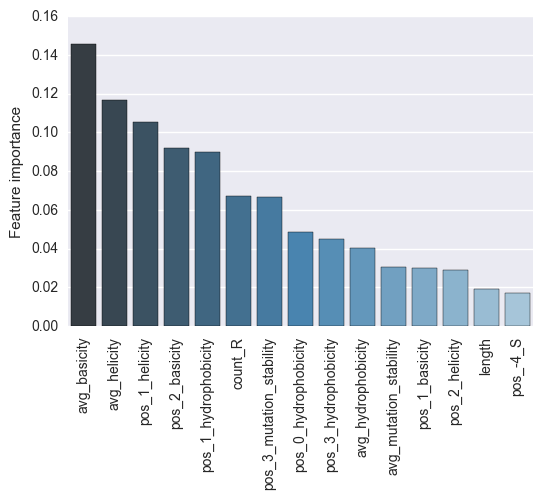

In [10]:
plt.figure(figsize=(width, height))

sns.barplot(x=significant_features.index.values, y=significant_features, palette='Blues_d')

plt.xticks(rotation='vertical', fontsize=10)
plt.ylabel('Feature importance')

plt.savefig('feature_importance.pdf', bbox_inches='tight', dpi=600)

print(significant_features)

### Learning curve

**TODO**: show that more data would be better

In [11]:
# compute the learning curve
selected_features = np.mean(feature_importances, axis=0) > 0.01
X_filtered = X[:, selected_features]
train_sizes, train_scores, test_scores = model_selection.learning_curve(
    classifier, X_filtered, y, train_sizes=np.linspace(.1, 1., 10), scoring='accuracy', n_jobs=-1,
    cv=model_selection.StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

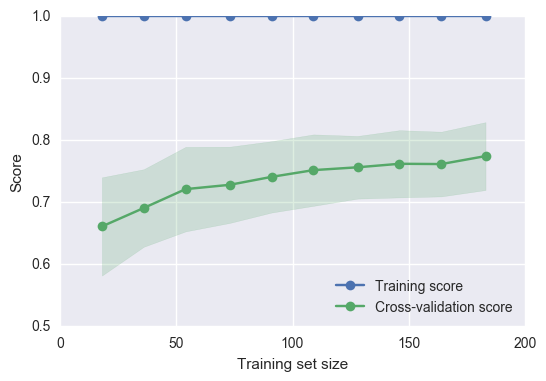

In [12]:
# plot the learning curve
plt.figure(figsize=(width, height))

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color=sns.color_palette()[0])
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')

plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color=sns.color_palette()[1])
plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')

plt.xlabel('Training set size')
plt.ylabel('Score')

plt.ylim(0.5, 1.05)

plt.legend(loc='lower right')

plt.savefig('learning_curve.pdf', bbox_inches='tight', dpi=600)